In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from imblearn.over_sampling import SMOTE

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cek Dataset
df = pd.read_csv('/content/drive/My Drive/Bengkel Koding/Telco-Customer-Churn.csv')

# Baca dataset
df.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [ ]:
# Cek tipe data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
# Memeriksa ringkasan statistik
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


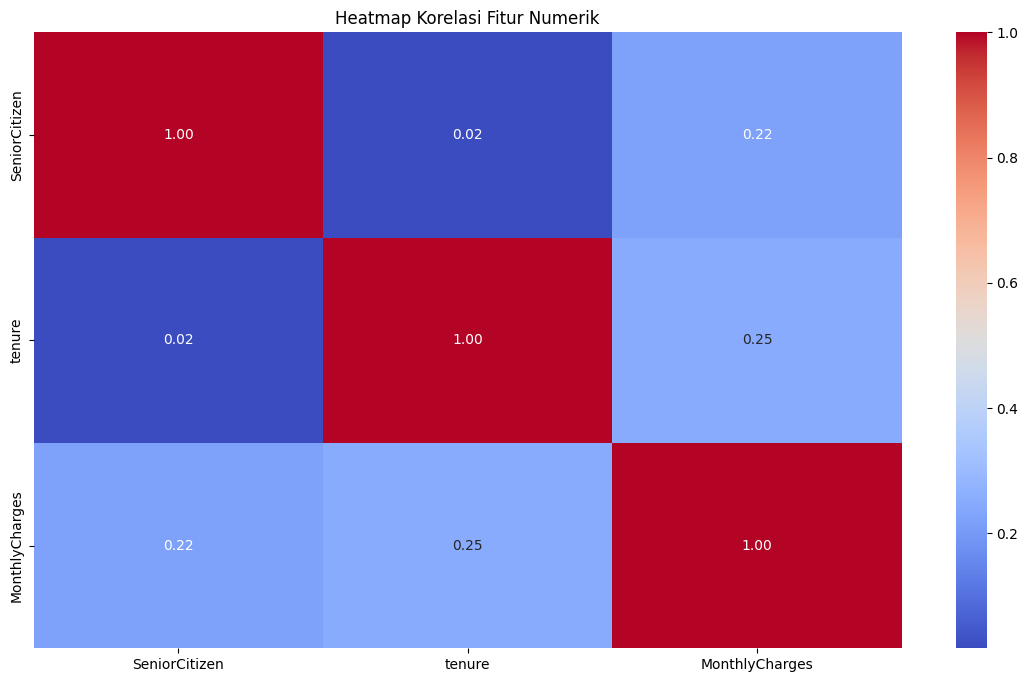

In [ ]:
# heatmap korelasi
plt.figure(figsize=(14,8))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Heatmap Korelasi Fitur Numerik")
plt.show()

In [ ]:
# Buang data yang targetnya kosong
df = df.dropna(subset=['Churn']).reset_index(drop=True)

# Ubah target jadi biner: No=1, Yes=0
df['Churn_bin'] = df['Churn'].map({'Yes':1, 'No':0})

# Tentukan fitur dan target
X_direct = df.drop(columns=['customerID', 'Churn', 'Churn_bin'])
y_direct = df['Churn_bin']

# Pisahkan fitur numerik dan kategorikal
num_cols = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

cat_cols = [
    'gender', 'Partner', 'Dependents',
    'PhoneService', 'MultipleLines',
    'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV',
    'StreamingMovies', 'Contract', 'PaperlessBilling',
    'PaymentMethod'
]

print("Jumlah fitur numerik:", len(num_cols))
print("Jumlah fitur kategorikal:", len(cat_cols))
print("\nContoh fitur numerik:", num_cols[:5])
print("Contoh fitur kategorikal:", cat_cols[:5])

Jumlah fitur numerik: 4
Jumlah fitur kategorikal: 15

Contoh fitur numerik: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Contoh fitur kategorikal: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines']


In [ ]:
# Label encode semua kolom object
for col in X_direct.select_dtypes(include="object"):
    X_direct[col] = LabelEncoder().fit_transform(X_direct[col])

In [ ]:
# Split Data 80:20
X_train_direct, X_test_direct, y_train_direct, y_test_direct = train_test_split(X_direct, y_direct, test_size=0.2,
                                                    random_state=42, stratify=y_direct)

print("Train shape:", X_train_direct.shape)
print("Test shape :", X_test_direct.shape)


Train shape: (5634, 19)
Test shape : (1409, 19)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


===== Evaluasi Model: Logistic Regression =====
Akurasi : 0.7970191625266146
Presisi : 0.787572630093222
Recall  : 0.7970191625266146
F1 Score: 0.7900980666183781

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1035
           1       0.64      0.53      0.58       374

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



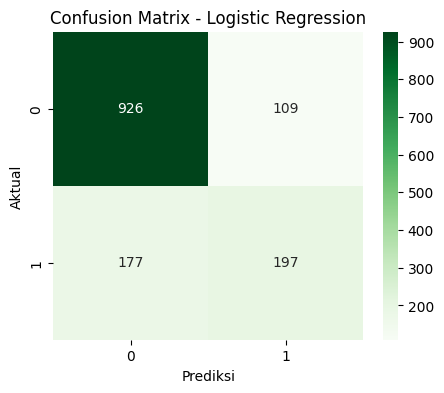

In [ ]:
lr_model_direct = LogisticRegression(max_iter=1000, random_state=42)
lr_model_direct.fit(X_train_direct, y_train_direct)

y_pred_lr_direct = lr_model_direct.predict(X_test_direct)

print("===== Evaluasi Model: Logistic Regression =====")
print("Akurasi :", accuracy_score(y_test_direct, y_pred_lr_direct))
print("Presisi :", precision_score(y_test_direct, y_pred_lr_direct, average='weighted'))
print("Recall  :", recall_score(y_test_direct, y_pred_lr_direct, average='weighted'))
print("F1 Score:", f1_score(y_test_direct, y_pred_lr_direct, average='weighted'))
print("\nClassification Report:")
print(classification_report(y_test_direct, y_pred_lr_direct))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test_direct, y_pred_lr_direct), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

===== Evaluasi Model: Random Forest =====
Akurasi : 0.7877927608232789
Presisi : 0.7757990350149997
Recall  : 0.7877927608232789
F1 Score: 0.7783747942324148

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.63      0.49      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409



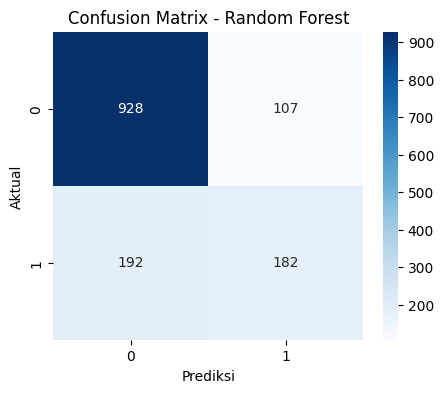

In [ ]:
rf_model_direct = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model_direct.fit(X_train_direct, y_train_direct)

y_pred_rf_direct = rf_model_direct.predict(X_test_direct)

print("===== Evaluasi Model: Random Forest =====")
print("Akurasi :", accuracy_score(y_test_direct, y_pred_rf_direct))
print("Presisi :", precision_score(y_test_direct, y_pred_rf_direct, average='weighted'))
print("Recall  :", recall_score(y_test_direct, y_pred_rf_direct, average='weighted'))
print("F1 Score:", f1_score(y_test_direct, y_pred_rf_direct, average='weighted'))
print("\nClassification Report:")
print(classification_report(y_test_direct, y_pred_rf_direct))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test_direct, y_pred_rf_direct), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


===== Evaluasi Model: Voting Classifier (LR + KNN + SVM) =====
Akurasi : 0.7785663591199432
Presisi : 0.7607826151274947
Recall  : 0.7785663591199432
F1 Score: 0.7535891114820584

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      1035
           1       0.66      0.35      0.46       374

    accuracy                           0.78      1409
   macro avg       0.73      0.64      0.66      1409
weighted avg       0.76      0.78      0.75      1409



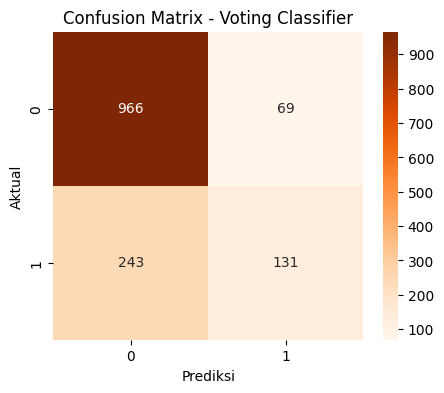

In [ ]:
voting_model_direct = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=1000)),
        ('knn', KNeighborsClassifier()),
        ('svm', SVC(probability=True))
    ],
    voting='soft'
)

voting_model_direct.fit(X_train_direct, y_train_direct)
y_pred_vote_direct = voting_model_direct.predict(X_test_direct)

print("===== Evaluasi Model: Voting Classifier (LR + KNN + SVM) =====")
print("Akurasi :", accuracy_score(y_test_direct, y_pred_vote_direct))
print("Presisi :", precision_score(y_test_direct, y_pred_vote_direct, average='weighted'))
print("Recall  :", recall_score(y_test_direct, y_pred_vote_direct, average='weighted'))
print("F1 Score:", f1_score(y_test_direct, y_pred_vote_direct, average='weighted'))
print("\nClassification Report:")
print(classification_report(y_test_direct, y_pred_vote_direct))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test_direct, y_pred_vote_direct), annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - Voting Classifier")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

,Model,Accuracy,F1_Score
0,Logistic Regression,0.797019,0.790098
1,Random Forest,0.787793,0.778375
2,Voting Classifier,0.778566,0.753589


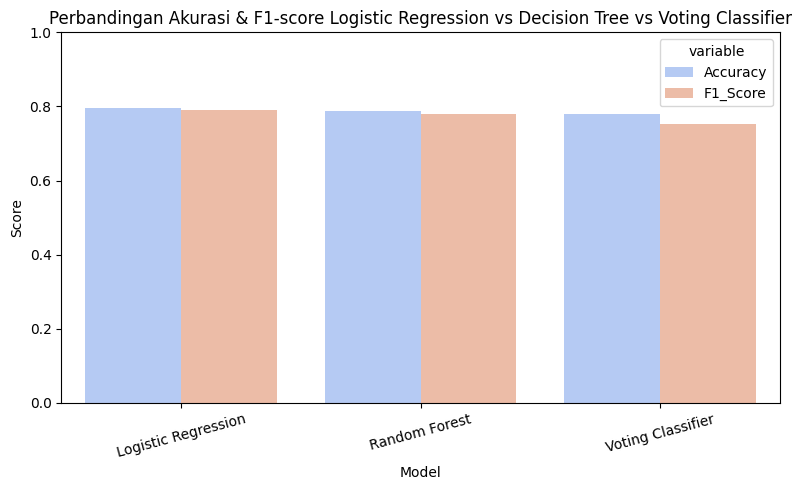

In [ ]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Voting Classifier'],
    'Accuracy': [
        accuracy_score(y_test_direct, y_pred_lr_direct),
        accuracy_score(y_test_direct, y_pred_rf_direct),
        accuracy_score(y_test_direct, y_pred_vote_direct)
    ],
    'F1_Score': [
        f1_score(y_test_direct, y_pred_lr_direct, average='weighted'),
        f1_score(y_test_direct, y_pred_rf_direct, average='weighted'),
        f1_score(y_test_direct, y_pred_vote_direct, average='weighted')
    ]
})

display(results)

plt.figure(figsize=(8,5))
sns.barplot(
    data=results.melt(id_vars='Model', value_vars=['Accuracy', 'F1_Score']),
    x='Model', y='value', hue='variable', palette='coolwarm'
)
plt.title('Perbandingan Akurasi & F1-score Logistic Regression vs Decision Tree vs Voting Classifier')
plt.ylabel('Score')
plt.ylim(0,1)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [ ]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

df = df.drop(columns=['customerID'])

# Buang data yang targetnya kosong
df = df.dropna(subset=['Churn']).reset_index(drop=True)

# Ubah target jadi biner: No=1, Yes=0
df['Churn_bin'] = df['Churn'].map({'Yes':1, 'No':0})

X = df.drop(columns=['Churn', 'Churn_bin'])
y = df['Churn_bin']

num_cols_pre = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

cat_cols_pre = [
    'gender', 'Partner', 'Dependents',
    'PhoneService', 'MultipleLines',
    'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV',
    'StreamingMovies', 'Contract', 'PaperlessBilling',
    'PaymentMethod'
]

print("Jumlah fitur numerik:", len(num_cols_pre))
print("Jumlah fitur kategorikal:", len(cat_cols_pre))
print("\nContoh fitur numerik:", num_cols_pre[:5])
print("Contoh fitur kategorikal:", cat_cols_pre[:5])


Jumlah fitur numerik: 4
Jumlah fitur kategorikal: 15

Contoh fitur numerik: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Contoh fitur kategorikal: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines']


In [ ]:
# 4. Tampilkan unique values dari semua kolom
for col in df.columns:
    print(f"\n=== Kolom: {col} ===")
    print(f"Jumlah unique values: {df[col].nunique()}")
    print("Nilai unik:")
    print(df[col].unique())


=== Kolom: gender ===
Jumlah unique values: 2
Nilai unik:
['Female' 'Male']

=== Kolom: SeniorCitizen ===
Jumlah unique values: 2
Nilai unik:
[0 1]

=== Kolom: Partner ===
Jumlah unique values: 2
Nilai unik:
['Yes' 'No']

=== Kolom: Dependents ===
Jumlah unique values: 2
Nilai unik:
['No' 'Yes']

=== Kolom: tenure ===
Jumlah unique values: 73
Nilai unik:
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]

=== Kolom: PhoneService ===
Jumlah unique values: 2
Nilai unik:
['No' 'Yes']

=== Kolom: MultipleLines ===
Jumlah unique values: 3
Nilai unik:
['No phone service' 'No' 'Yes']

=== Kolom: InternetService ===
Jumlah unique values: 3
Nilai unik:
['DSL' 'Fiber optic' 'No']

=== Kolom: OnlineSecurity ===
Jumlah unique values: 3
Nilai unik:
['No' 'Yes' 'No internet service']

=== Kolom: OnlineBackup ===
Jumlah unique va

In [ ]:
for col in df.columns:
    print(f"\n=== {col} ===")
    print(df[col].value_counts())



=== gender ===
gender
Male      3555
Female    3488
Name: count, dtype: int64

=== SeniorCitizen ===
SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64

=== Partner ===
Partner
No     3641
Yes    3402
Name: count, dtype: int64

=== Dependents ===
Dependents
No     4933
Yes    2110
Name: count, dtype: int64

=== tenure ===
tenure
1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: count, Length: 73, dtype: int64

=== PhoneService ===
PhoneService
Yes    6361
No      682
Name: count, dtype: int64

=== MultipleLines ===
MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64

=== InternetService ===
InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64

=== OnlineSecurity ===
OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64

=== OnlineB

In [ ]:
# Cek missing value
df.isnull().sum()

,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0
OnlineBackup,0


In [ ]:
# Filter kolom dengan tipe data 'object' (yang biasanya berisi teks)
object_cols = df.select_dtypes(include='object').columns

# Hitung persentase missing value untuk kolom-kolom object
missing_object_percentage = df[object_cols].isnull().sum() / len(df) * 100
missing_object_percentage = missing_object_percentage.sort_values(ascending=False)

print("Persentase Missing Value untuk Kolom Teks (Object) :\n", missing_object_percentage)

Persentase Missing Value untuk Kolom Teks (Object) :
 gender              0.0
Partner             0.0
Dependents          0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
Churn               0.0
dtype: float64


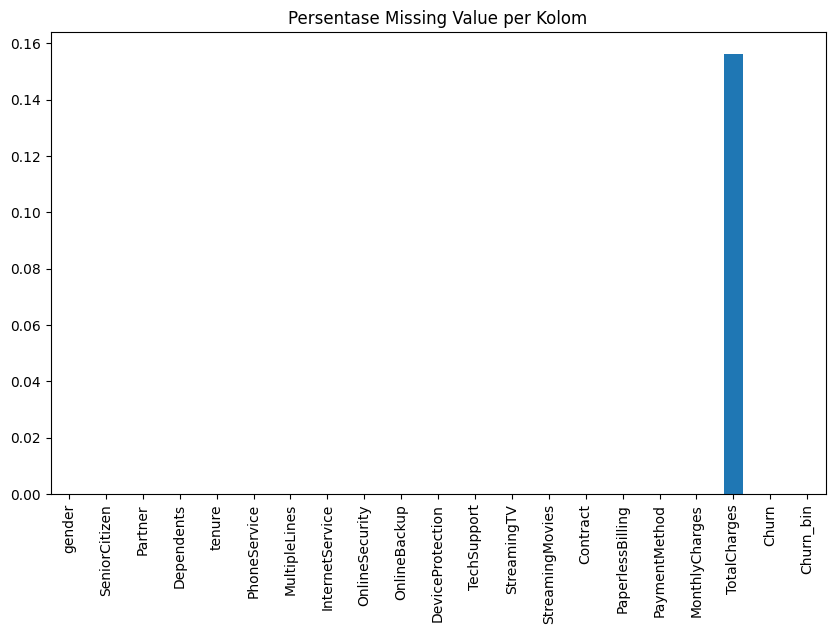

In [ ]:
# Hitung jumlah dan persentase missing value untuk setiap kolom
missing_counts = df.isnull().sum()
missing_percent = (missing_counts / len(df)) * 100

# Visualisasi dalam bentuk diagram batang
plt.figure(figsize=(10,6))
missing_percent.plot(kind='bar')
plt.title('Persentase Missing Value per Kolom')
plt.show()

In [ ]:
# Imputasi missing value
df[num_cols_pre] = df[num_cols_pre].fillna(df[num_cols_pre].median())

for col in cat_cols_pre:
    df[col] = df[col].fillna(df[col].mode()[0])

In [ ]:
# cek apakah sudah bersih
print(df.isnull().sum().sum(), "missing value tersisa")
df.isnull().sum()

0 missing value tersisa


,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0
OnlineBackup,0


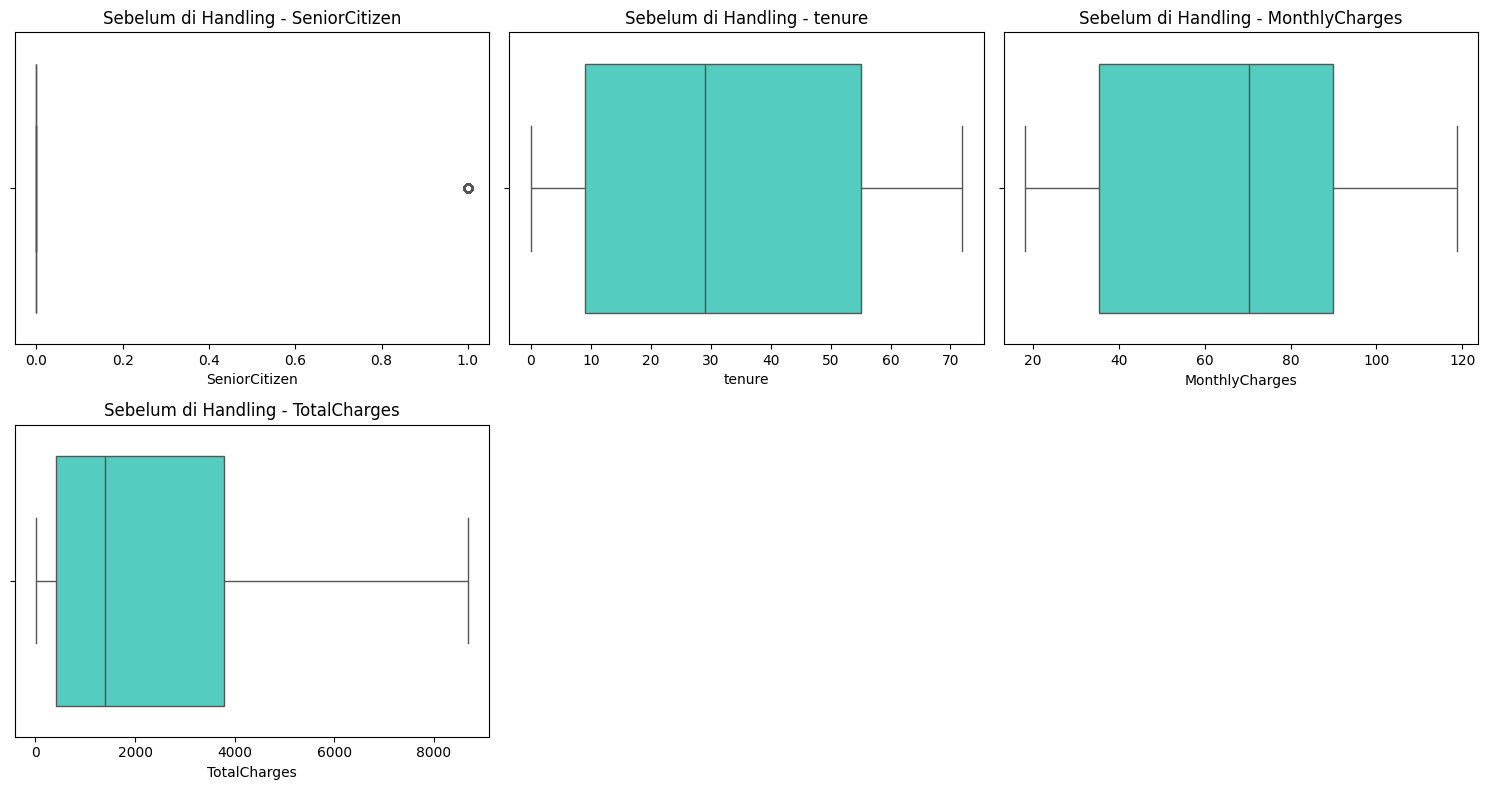

In [ ]:
# Cek outlier
# num_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Tampilkan boxplot awal (sebelum penanganan)
plt.figure(figsize=(15, 8))
for i, col in enumerate(num_cols_pre):
    plt.subplot((len(num_cols_pre)//3)+1, 3, i+1)
    sns.boxplot(x=df[col], color='turquoise')
    plt.title(f"Sebelum di Handling - {col}")
plt.tight_layout()
plt.show()

In [ ]:
# One-hot encoding untuk fitur kategorikal
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_cat = pd.DataFrame(encoder.fit_transform(df[cat_cols_pre]), columns=encoder.get_feature_names_out(cat_cols))

# Simpan nama kolom hasil encoding
encoded_cat.columns = encoder.get_feature_names_out(cat_cols_pre)

# Gabungkan hasil encoding ke fitur numerik
df_encoded = pd.concat([df[num_cols_pre].reset_index(drop=True), encoded_cat], axis=1)

# Tambahkan kolom target
df_encoded['Churn_bin'] = df['Churn_bin'].values

In [ ]:
# Split Data 80:20

X = df_encoded.drop(columns=['Churn_bin'])
y = df_encoded['Churn_bin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)


Train shape: (5634, 45)
Test shape : (1409, 45)


/tmp/ipython-input-136945182.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette='coolwarm')


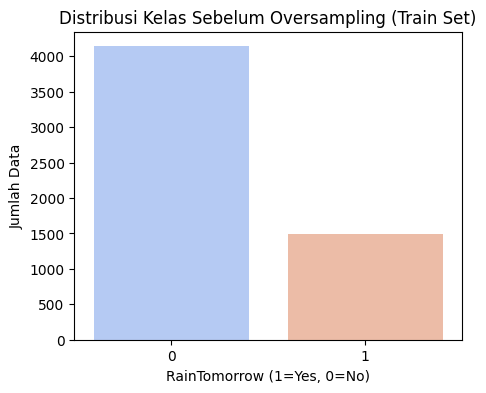

Jumlah sampel tiap kelas sebelum SMOTE:
Churn_bin
0    4139
1    1495
Name: count, dtype: int64


In [ ]:
# Cek distribusi awal
plt.figure(figsize=(5,4))
sns.countplot(x=y_train, palette='coolwarm')
plt.title("Distribusi Kelas Sebelum Oversampling (Train Set)")
plt.xlabel("RainTomorrow (1=Yes, 0=No)")
plt.ylabel("Jumlah Data")
plt.show()

print("Jumlah sampel tiap kelas sebelum SMOTE:")
print(y_train.value_counts())

/tmp/ipython-input-3269501518.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_over, palette='coolwarm')


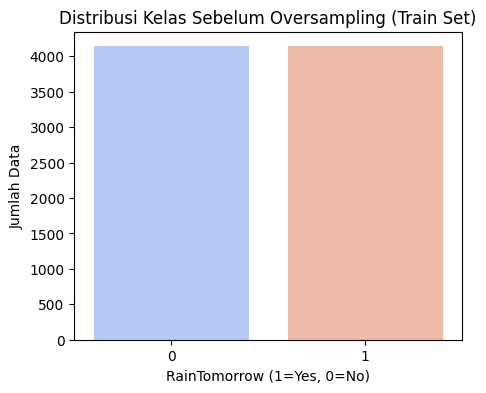

Jumlah sampel tiap kelas sebelum SMOTE:
Churn_bin
0    4139
1    4139
Name: count, dtype: int64


In [ ]:
smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

# Cek distribusi setelah dilakukan smote
plt.figure(figsize=(5,4))
sns.countplot(x=y_train_over, palette='coolwarm')
plt.title("Distribusi Kelas Sebelum Oversampling (Train Set)")
plt.xlabel("RainTomorrow (1=Yes, 0=No)")
plt.ylabel("Jumlah Data")
plt.show()

print("Jumlah sampel tiap kelas sebelum SMOTE:")
print(y_train_over.value_counts())

In [ ]:
# Stadarisasi

scaler = StandardScaler()

X_train_scaled = X_train_over.copy()
X_test_scaled  = X_test.copy()

X_train_scaled[num_cols_pre] = scaler.fit_transform(X_train_over[num_cols_pre])
X_test_scaled[num_cols_pre]  = scaler.transform(X_test[num_cols_pre])

In [ ]:
feature_names = X_train_scaled.columns.tolist()

print("Jumlah fitur:", len(feature_names))
print(feature_names)


Jumlah fitur: 45
['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'gender_Female', 'gender_Male', 'Partner_No', 'Partner_Yes', 'Dependents_No', 'Dependents_Yes', 'PhoneService_No', 'PhoneService_Yes', 'MultipleLines_No', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_No', 'PaperlessBilling_Yes', 'PaymentMethod_Bank transfer (automatic)', 'Paym

===== Evaluasi Model: Logistic Regression =====
Akurasi : 0.7274662881476224
Presisi : 0.7840356509120179
Recall  : 0.7274662881476224
F1 Score: 0.7416405747023671

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.72      0.79      1035
           1       0.49      0.75      0.59       374

    accuracy                           0.73      1409
   macro avg       0.69      0.74      0.69      1409
weighted avg       0.78      0.73      0.74      1409



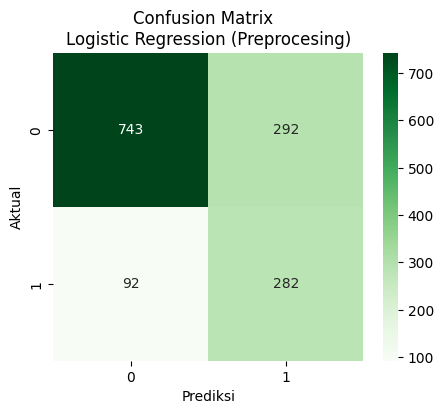

In [ ]:
lr_model_pre = LogisticRegression(max_iter=1000, random_state=42)
lr_model_pre.fit(X_train_scaled, y_train_over)

y_pred_lr_pre = lr_model_pre.predict(X_test_scaled)

print("===== Evaluasi Model: Logistic Regression =====")
print("Akurasi :", accuracy_score(y_test, y_pred_lr_pre))
print("Presisi :", precision_score(y_test, y_pred_lr_pre, average='weighted'))
print("Recall  :", recall_score(y_test, y_pred_lr_pre, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_lr_pre, average='weighted'))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr_pre))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_lr_pre), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix  \nLogistic Regression (Preprocesing)")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

===== Evaluasi Model: Random Forest =====
Akurasi : 0.7757274662881476
Presisi : 0.7648430638714974
Recall  : 0.7757274662881476
F1 Score: 0.7683404541456812

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1035
           1       0.59      0.49      0.54       374

    accuracy                           0.78      1409
   macro avg       0.71      0.68      0.69      1409
weighted avg       0.76      0.78      0.77      1409



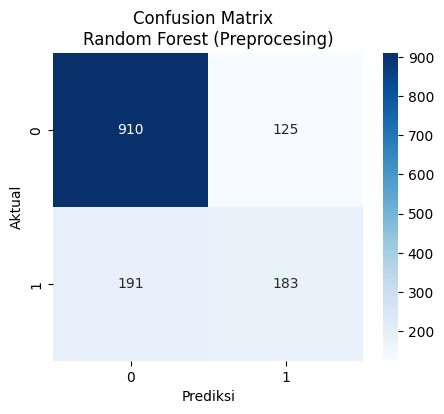

In [ ]:
rf_model_pre = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model_pre.fit(X_train_over, y_train_over)

y_pred_rf_pre = rf_model_pre.predict(X_test)

print("===== Evaluasi Model: Random Forest =====")
print("Akurasi :", accuracy_score(y_test, y_pred_rf_pre))
print("Presisi :", precision_score(y_test, y_pred_rf_pre, average='weighted'))
print("Recall  :", recall_score(y_test, y_pred_rf_pre, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_rf_pre, average='weighted'))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_pre))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf_pre), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix  \nRandom Forest (Preprocesing)")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

===== Evaluasi Model: Voting Classifier (LR + KNN + SVM) =====
Akurasi : 0.7473385379701917
Presisi : 0.7832894133312224
Recall  : 0.7473385379701917
F1 Score: 0.7580916578883019

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.76      0.82      1035
           1       0.52      0.71      0.60       374

    accuracy                           0.75      1409
   macro avg       0.70      0.74      0.71      1409
weighted avg       0.78      0.75      0.76      1409



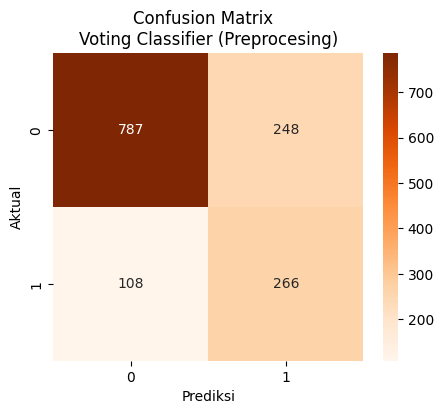

In [ ]:
voting_model_pre = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=1000)),
        ('knn', KNeighborsClassifier()),
        ('svm', SVC(probability=True))
    ],
    voting='soft'
)

voting_model_pre.fit(X_train_scaled, y_train_over)
y_pred_vote_pre = voting_model_pre.predict(X_test_scaled)

print("===== Evaluasi Model: Voting Classifier (LR + KNN + SVM) =====")
print("Akurasi :", accuracy_score(y_test, y_pred_vote_pre))
print("Presisi :", precision_score(y_test, y_pred_vote_pre, average='weighted'))
print("Recall  :", recall_score(y_test, y_pred_vote_pre, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_vote_pre, average='weighted'))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_vote_pre))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_vote_pre), annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix  \nVoting Classifier (Preprocesing)")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

,Model,Accuracy,F1_Score
0,Logistic Regression,0.727466,0.741641
1,Random Forest,0.775727,0.768340
2,Voting Classifier,0.747339,0.758092


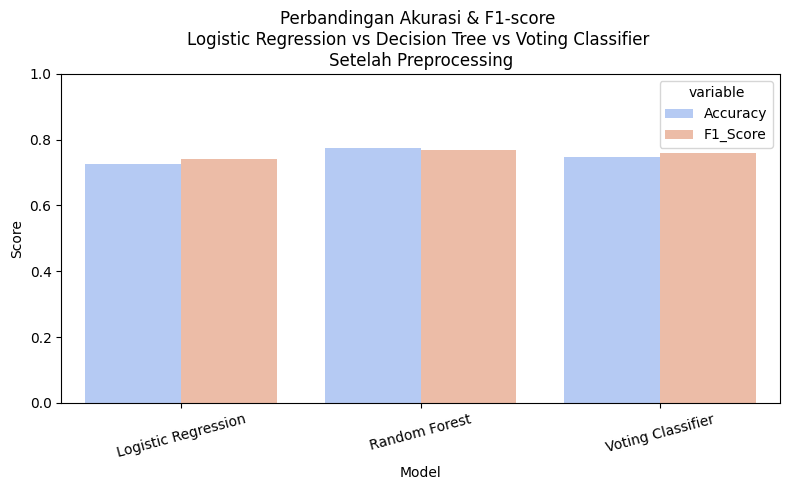

In [ ]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Voting Classifier'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr_pre),
        accuracy_score(y_test, y_pred_rf_pre),
        accuracy_score(y_test, y_pred_vote_pre)
    ],
    'F1_Score': [
        f1_score(y_test, y_pred_lr_pre, average='weighted'),
        f1_score(y_test, y_pred_rf_pre, average='weighted'),
        f1_score(y_test, y_pred_vote_pre, average='weighted')
    ]
})

display(results)

plt.figure(figsize=(8,5))
sns.barplot(
    data=results.melt(id_vars='Model', value_vars=['Accuracy', 'F1_Score']),
    x='Model', y='value', hue='variable', palette='coolwarm'
)
plt.title('Perbandingan Akurasi & F1-score \nLogistic Regression vs Decision Tree vs Voting Classifier \nSetelah Preprocessing')
plt.ylabel('Score')
plt.ylim(0,1)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

,Model,Accuracy,F1_Score
0,Logistic Regression,0.797019,0.790098
1,Logistic Regression (Prep),0.727466,0.741641
2,Random Forest,0.787793,0.778375
3,Random Forest (Prep),0.775727,0.768340
4,Voting Classifier,0.778566,0.753589
5,Voting Classifier (Prep),0.747339,0.758092


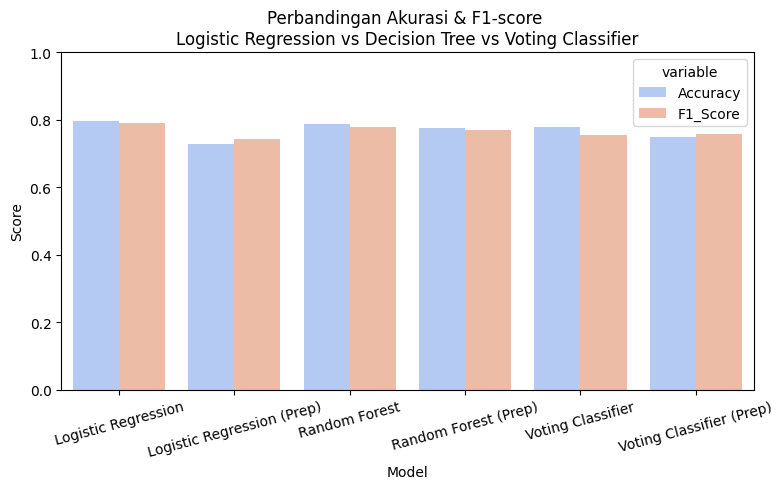

In [ ]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Logistic Regression (Prep)', 'Random Forest', 'Random Forest (Prep)',
              'Voting Classifier', 'Voting Classifier (Prep)'],
    'Accuracy': [
        accuracy_score(y_test_direct, y_pred_lr_direct),
        accuracy_score(y_test, y_pred_lr_pre),
        accuracy_score(y_test_direct, y_pred_rf_direct),
        accuracy_score(y_test, y_pred_rf_pre),
        accuracy_score(y_test_direct, y_pred_vote_direct),
        accuracy_score(y_test, y_pred_vote_pre)
    ],
    'F1_Score': [
        f1_score(y_test_direct, y_pred_lr_direct, average='weighted'),
        f1_score(y_test, y_pred_lr_pre, average='weighted'),
        f1_score(y_test_direct, y_pred_rf_direct, average='weighted'),
        f1_score(y_test, y_pred_rf_pre, average='weighted'),
        f1_score(y_test_direct, y_pred_vote_direct, average='weighted'),
        f1_score(y_test, y_pred_vote_pre, average='weighted')
    ]
})

display(results)

plt.figure(figsize=(8,5))
sns.barplot(
    data=results.melt(id_vars='Model', value_vars=['Accuracy', 'F1_Score']),
    x='Model', y='value', hue='variable', palette='coolwarm'
)
plt.title('Perbandingan Akurasi & F1-score \nLogistic Regression vs Decision Tree vs Voting Classifier')
plt.ylabel('Score')
plt.ylim(0,1)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

===== Logistic Regression (Best Params) =====
LogisticRegression(C=100, max_iter=1000, random_state=42, solver='liblinear')

--- Evaluasi Logistic Regression ---
Accuracy : 0.7288857345635202
Precision: 0.4930313588850174
Recall   : 0.7566844919786097
F1-Score : 0.5970464135021097

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.72      0.79      1035
           1       0.49      0.75      0.59       374

    accuracy                           0.73      1409
   macro avg       0.69      0.74      0.69      1409
weighted avg       0.78      0.73      0.74      1409



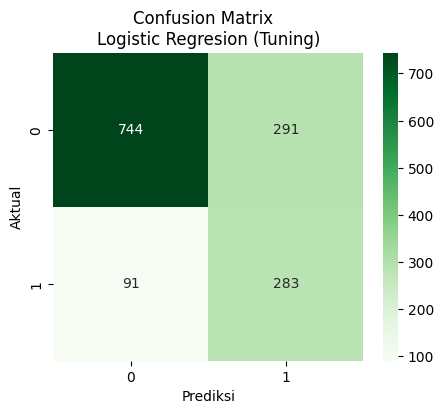

In [ ]:
# Logistic Regression — RandomizedSearch
lr = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)

param_lr = {
    'C': [0.01, 0.1, 1, 10, 100]
}

rand_lr = RandomizedSearchCV(
    lr, param_lr,
    n_iter=5,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    random_state=42
)

rand_lr.fit(X_train_scaled, y_train_over)
best_lr = rand_lr.best_estimator_

print("===== Logistic Regression (Best Params) =====")
print(best_lr)

# Evaluasi
y_pred_lr = best_lr.predict(X_test_scaled)

print("\n--- Evaluasi Logistic Regression ---")
print("Accuracy :", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall   :", recall_score(y_test, y_pred_lr))
print("F1-Score :", f1_score(y_test, y_pred_lr))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr_pre))

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix  \nLogistic Regresion (Tuning)")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
12 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_p

===== Random Forest (Best Params) =====
RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=150, random_state=42)

--- Evaluasi Random Forest ---
Accuracy : 0.7771469127040455
Precision: 0.7815206199230209
Recall   : 0.7771469127040455
F1-Score : 0.7791335634125013

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1035
           1       0.58      0.61      0.59       374

    accuracy                           0.78      1409
   macro avg       0.72      0.72      0.72      1409
weighted avg       0.78      0.78      0.78      1409



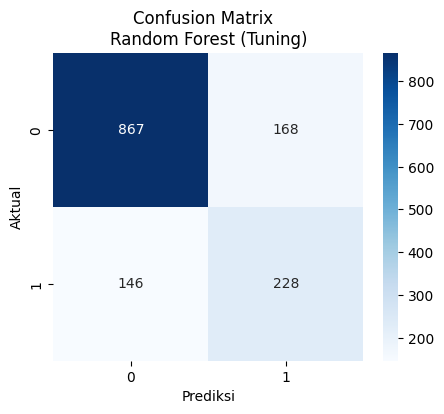

In [ ]:
# Random Forest — RandomizedSearch
rf = RandomForestClassifier(random_state=42)

param_rf = {
    'n_estimators': [100, 150, 200, 300, 400],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': ['auto', 'sqrt', 0.25, 0.5],
    'bootstrap': [True, False]
}

rand_rf = RandomizedSearchCV(
    rf, param_rf,
    n_iter=20,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    random_state=42
)

# Train tanpa scaling (RF tidak butuh scaling)
rand_rf.fit(X_train_over, y_train_over)
best_rf = rand_rf.best_estimator_

print("===== Random Forest (Best Params) =====")
print(best_rf)

# Evaluasi
y_pred_rf = best_rf.predict(X_test)

print("\n--- Evaluasi Random Forest ---")
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_rf, average='weighted'))
print("F1-Score :", f1_score(y_test, y_pred_rf, average='weighted'))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix  \nRandom Forest (Tuning)")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()


===== Evaluasi Voting Classifier =====
Accuracy : 0.723207948899929
Precision: 0.4865771812080537
Recall   : 0.7754010695187166
F1-Score : 0.5979381443298969

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1035
           1       0.49      0.78      0.60       374

    accuracy                           0.72      1409
   macro avg       0.69      0.74      0.69      1409
weighted avg       0.79      0.72      0.74      1409



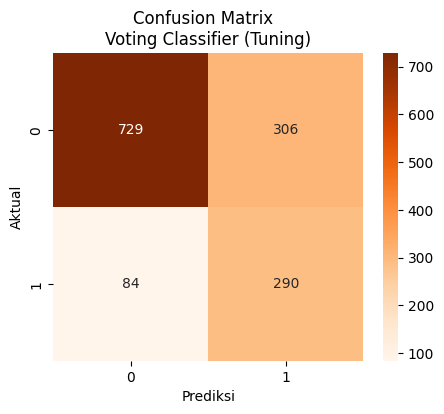

In [ ]:
# Tuning Logistic Regression (untuk Voting)
lr = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)

param_lr = {
    'C': [0.01, 0.1, 1, 10, 100]
}

rand_lr = RandomizedSearchCV(
    lr, param_lr,
    n_iter=5,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    random_state=42
)

rand_lr.fit(X_train_scaled, y_train_over)
best_lr = rand_lr.best_estimator_


# Tuning KNN (untuk Voting)
knn = KNeighborsClassifier()

param_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance']
}

rand_knn = RandomizedSearchCV(
    knn, param_knn,
    n_iter=8,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    random_state=42
)

rand_knn.fit(X_train_scaled, y_train_over)
best_knn = rand_knn.best_estimator_


# Tuning SVM (linear agar cepat)
svm = SVC(probability=True, random_state=42)

param_svm = {
    'C': [0.1, 0.5, 1, 3, 5],
    'kernel': ['linear']   # hanya linear → cepat
}

rand_svm = RandomizedSearchCV(
    svm, param_svm,
    n_iter=5,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    random_state=42
)

rand_svm.fit(X_train_scaled, y_train_over)
best_svm = rand_svm.best_estimator_


# Membangun Voting Classifier (SOFT VOTING)
voting = VotingClassifier(
    estimators=[
        ('lr', best_lr),
        ('knn', best_knn),
        ('svm', best_svm)
    ],
    voting='soft'
)

voting.fit(X_train_scaled, y_train_over)
best_voting = voting


# Evaluasi Voting Classifier
y_pred_vote = best_voting.predict(X_test_scaled)

accuracy_vote = accuracy_score(y_test, y_pred_vote)
precision_vote = precision_score(y_test, y_pred_vote)
recall_vote = recall_score(y_test, y_pred_vote)
f1_vote = f1_score(y_test, y_pred_vote)

print("===== Evaluasi Voting Classifier =====")
print("Accuracy :", accuracy_vote)
print("Precision:", precision_vote)
print("Recall   :", recall_vote)
print("F1-Score :", f1_vote)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_vote))

# Confusion Matrix Voting Classifier
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_vote), annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix  \nVoting Classifier (Tuning)")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

,Model,Accuracy,F1_Score
0,Logistic Regression (Prep),0.727466,0.741641
1,Logistic Regression (Tuning),0.728886,0.742986
2,Random Forest (Prep),0.775727,0.768340
3,Random Forest (Tuning),0.777147,0.779134
4,Voting Classifier (Prep),0.747339,0.758092
5,Voting Classifier (Tuning),0.723208,0.738257


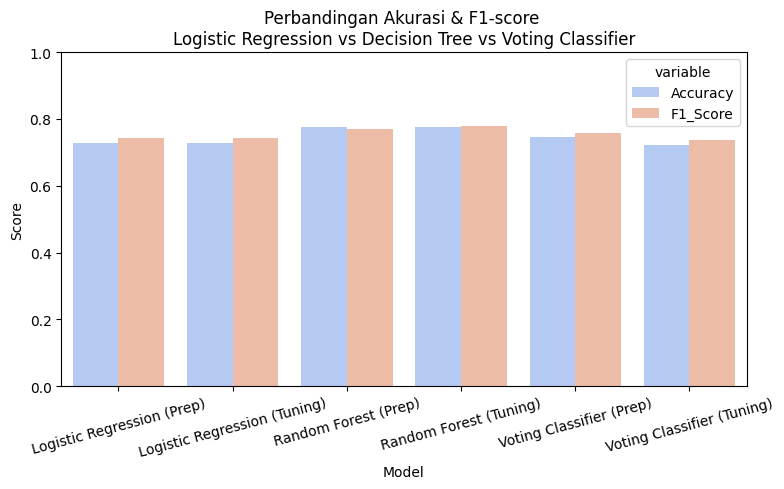

In [ ]:
results = pd.DataFrame({
    'Model': ['Logistic Regression (Prep)', 'Logistic Regression (Tuning)', 'Random Forest (Prep)', 'Random Forest (Tuning)',
              'Voting Classifier (Prep)', 'Voting Classifier (Tuning)'],
    'Accuracy': [
        accuracy_score(y_test_direct, y_pred_lr_pre),
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test_direct, y_pred_rf_pre),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test_direct, y_pred_vote_pre),
        accuracy_score(y_test, y_pred_vote)
    ],
    'F1_Score': [
        f1_score(y_test_direct, y_pred_lr_pre, average='weighted'),
        f1_score(y_test, y_pred_lr, average='weighted'),
        f1_score(y_test_direct, y_pred_rf_pre, average='weighted'),
        f1_score(y_test, y_pred_rf, average='weighted'),
        f1_score(y_test_direct, y_pred_vote_pre, average='weighted'),
        f1_score(y_test, y_pred_vote, average='weighted')
    ]
})

display(results)

plt.figure(figsize=(8,5))
sns.barplot(
    data=results.melt(id_vars='Model', value_vars=['Accuracy', 'F1_Score']),
    x='Model', y='value', hue='variable', palette='coolwarm'
)
plt.title('Perbandingan Akurasi & F1-score \nLogistic Regression vs Decision Tree vs Voting Classifier')
plt.ylabel('Score')
plt.ylim(0,1)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
plt.show()
plt.show()

In [ ]:
import joblib

joblib.dump(
    {
        "model": best_rf,
        "encoder": encoder,
        "num_cols": num_cols_pre,
        "cat_cols": cat_cols,
        "feature_names": X_train_over.columns.tolist(),
        "X_test": X_test,
        "y_test": y_test
    },
    "random_forest_tuning.joblib"
)


['random_forest_tuning.joblib']